### NMR shieldings
* Moleküleingabe vom xyz- file, idealerweise aus DFT Optimierung
* Berechnung anisotroper Verschiebung
* Table1a CHESHIRE Kalibrierung Gasphase
* Table1b CHESHIRE Kalibrierung SMD Solvent Modell CDCl3
* Table1c CHESHIRE Kalibrierung CPCM/UAKS Chloroform Model
* TMS Kalibrierung gegen TMS in der Gasphase

In [9]:
#####################################
#
# Computing NMR shielding constants
# non gpu variante
#
######################################

jobname = "Oxetane"

# Filename vom Jobnamen bilden
xyzin =f"xyz/{jobname}.xyz"
logfile=f"logs/{jobname}.log"


import pyscf
from pyscf import gto, dft
from pyscf.prop import nmr

mol = pyscf.M(atom=xyzin, basis='6-31g*', output=logfile)


mf = dft.RKS(mol)
mf.xc = 'b3lyp'
mf.run()

#nmr.RKS(mf).kernel()

abschirmung = nmr.RKS(mf).kernel()


output file: logs/Oxetane.log


In [10]:
#################################################################################################
#
# Constanten für Verschiebungsberchnung
#
# CSHESHIRE Repository (Tantillo)
#
# Table 1a and 1b
#
# delta = (intercept -sigma)/ - slope
#
# Das Vorzeichen von slope wird gleich in die Definition der Konstanten eingepflegt
#
# TMS shielding aus eigener Berechnung delta = sigma - TMS
#
##################################################################################################

intercept1a = 187.4743
slope1a = 0.9269
intercept1b = 188.4418
slope1b = 0.9449
intercept1c = 188.01
slope1c = 0.9378
tmsshield = 190.2218

h_intercept1a = 32.2884
h_slope1a = 0.9957
h_intercept1b = 32.2109
h_slope1b = 1.0157
h_intercept1c = 32.2448
h_slope1c = 1.004
h_tmsshield = 32.1893

shift = [0] *mol.natm
shift1a = [0] *mol.natm
shift1b= [0] *mol.natm
shift1c= [0] *mol.natm
shifttms= [0] *mol.natm


data = []
for i in range(mol.natm):
    shift[i]= (abschirmung[i,0,0] + abschirmung[i,1,1] + abschirmung[i,2,2])/3
    #print(f"Atom {mol._atom[i][0]} {i} hat eine totale Abschirmung von {shift[i]} .")

    if  mol._atom[i][0] =='C':
        shift1a[i] = round(((intercept1a-shift[i])/slope1a),2)
        shift1b[i] = round(((intercept1b-shift[i])/slope1b),2)
        shift1c[i] = round(((intercept1c-shift[i])/slope1c),2)
        shifttms[i] = round((tmsshield - shift[i]),2)
        data.append({'Atom': mol._atom[i][0], 'Index': i+1, 'Totale Abschirmung': shift[i], 'table1a': shift1a[i], 'table1b' : shift1b[i], 'table1c' : shift1c[i], 'TMS' : shifttms[i]})

    if  mol._atom[i][0] =='H':
        shift1a[i] = round(((h_intercept1a-shift[i])/h_slope1a),2)
        shift1b[i] = round(((h_intercept1b-shift[i])/h_slope1b),2)
        shift1c[i] = round(((h_intercept1c-shift[i])/h_slope1c),2)
        shifttms[i] = round((h_tmsshield - shift[i]),2)
        data.append({'Atom': mol._atom[i][0], 'Index': i+1, 'Totale Abschirmung': shift[i], 'table1a': shift1a[i], 'table1b' : shift1b[i], 'table1c' : shift1c[i], 'TMS' : shifttms[i]})
 

In [11]:
import pandas as pd
from IPython.display import display, HTML
# Erstelle ein DataFrame
df = pd.DataFrame(data)

# Setze die Spaltenüberschriften
df.columns = ['Atom', 'Index', 'Totale Abschirmung', 'table1a', 'table1b', 'table1c', 'TMS']

# Zeige die Tabelle an
display(HTML(df.to_html(index=False)))

Atom,Index,Totale Abschirmung,table1a,table1b,table1c,TMS
C,2,167.700123,21.33,21.95,21.66,22.52
C,3,120.956782,71.76,71.42,71.50,69.27
C,4,120.956782,71.76,71.42,71.50,69.27
H,5,29.789469,2.51,2.38,2.45,2.40
H,6,29.789469,2.51,2.38,2.45,2.40
H,7,27.570852,4.74,4.57,4.66,4.62
H,8,27.570852,4.74,4.57,4.66,4.62
H,9,27.570852,4.74,4.57,4.66,4.62
H,10,27.570852,4.74,4.57,4.66,4.62


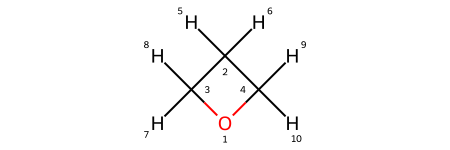

In [12]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDetermineBonds
from rdkit.Chem.Draw import IPythonConsole


def show_atom_number(mol, label):
    for atom in mol.GetAtoms():
        atom.SetProp(label, str(atom.GetIdx()+1))
    return mol

raw_mol = Chem.MolFromXYZFile(xyzin)
mol2 = Chem.Mol(raw_mol)
Chem.rdDetermineBonds.DetermineBonds(mol2)
# mol2
AllChem.Compute2DCoords(mol2)
show_atom_number(mol2, 'atomNote')